<h1>AMLBio 2021</h1>
<h3>Optimization Notebook</h3>



In [ ]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math
import random
from scipy.stats import spearmanr, pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/AMLBio/AMLBio_2021/master/utils.py
!pip install logomaker

import logomaker
from utils import *

--2021-02-08 09:39:50--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22100 (22K) [text/plain]
Saving to: ‘Functions_Final_v3_1.py.1’

Functions_Final_v3_ 100%[===================>]  21.58K  --.-KB/s    in 0.001s  

2021-02-08 09:39:50 (18.8 MB/s) - ‘Functions_Final_v3_1.py.1’ saved [22100/22100]



# Help for each imported function is available:

In [ ]:
help(random_combination_generator)

Help on function random_combination_generator in module Functions_Final_v3_1:

random_combination_generator(concentrations_limits, number_of_combination=100, reaction_vol_nl=10000, max_nl=None, drop_size_nl=100, check_repeat=True, rounded=2, verbose=0, make_csv=False, return_df=False)
    this function make random combination that is safe (e.g. dont make too much or low concentrated, not excecutable based on drop size, not repetitive)
    
    Parameters
    ----------
    concentrations_limits : dict
        {'name of metabolite': {'Conc_Min': #, 'Conc_Max': #, 'Conc_Values': #, 'Conc_Stock': #, 'Alternatives': #}, ...}
        
    Returns
    -------
    data : pandas.DataFrame
        a dataframe as consist of number_of_combination of random combinations



This notebook includes all data processing, bayesian optimization and results visualisation

# User Inputs

<p1><h2> When to use this part:</h2>
* every time before using BBO you should fill this part based on your project</p1>
<p1><h2> How to use this part:</h2>
* User should upload all available Results file (i.e. Results_1.csv to Results_n.csv) to runtime from Files/UploadFile
* now there is an example, change it to your project</p1>

In [ ]:
# General Parameters:
m = 50      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 9300 # (e.g. volume except fixed parts - 100 nl avoid 0 water)
fixed_parts = {}
days_total = 10 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 
exploration = {1: 2.0}
days_range = [m for i in range(days_total)]

In [ ]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'I48':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'Y134':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'E135':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'A415':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'M442':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'Y497':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'E567':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'S568':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'I571':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 }

In [ ]:
# Check Possible Concentrations
data_lists = {}
num = 0 

pool_size = 1

for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    print(concs)
    print(vols)
    
    pool_size *= len(concs)

    data_lists[num] = vols
    num += 1
    print()

print('All Possible Combination Number = ', pool_size)
if pool_size > 10000000: 
    pool_size = 10000000
    print('Percentage calculation is not availbe duo to large pool size!')
else:
    percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
    print(percent, f'% of {pool_size} possible combination are executable!')

Possible Conc For : I48
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : Y134
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : E135
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : A415
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : M442
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : Y497
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : E567
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : S568
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

Possible Conc For : I571
Your Min, Max : (0.0, 0.0)
[0.0]
[0]

All Possible Combination Number =  1
100.0 % of 1 possible combination are executable!


In [ ]:
# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***

specials = {}

# Day 1 (in absence of Day_0)

<p1><h2> When to use this part:</h2>
* after filling "User Input" if you have no pre existing data (Day_0.csv) 
<p1><h2> How to use this part:</h2>
* just run all cells!


In [ ]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [ ]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)
Volumes_1

,I48,I48_Type,Y134,Y134_Type,E135,E135_Type,A415,A415_Type,M442,M442_Type,Y497,Y497_Type,E567,E567_Type,S568,S568_Type,I571,I571_Type,water
0,0.0,M,0.0,G,0.0,W,0.0,G,0.0,S,0.0,G,0.0,T,0.0,E,0.0,L,20000.0
1,0.0,H,0.0,R,0.0,M,0.0,D,0.0,E,0.0,L,0.0,W,0.0,P,0.0,H,20000.0
2,0.0,M,0.0,A,0.0,S,0.0,M,0.0,H,0.0,P,0.0,S,0.0,S,0.0,V,20000.0
3,0.0,E,0.0,W,0.0,P,0.0,Q,0.0,I,0.0,H,0.0,W,0.0,Y,0.0,W,20000.0
4,0.0,A,0.0,W,0.0,V,0.0,V,0.0,E,0.0,F,0.0,Y,0.0,Y,0.0,Y,20000.0
5,0.0,R,0.0,W,0.0,K,0.0,R,0.0,D,0.0,A,0.0,F,0.0,L,0.0,R,20000.0
6,0.0,H,0.0,G,0.0,W,0.0,E,0.0,C,0.0,P,0.0,W,0.0,S,0.0,S,20000.0
7,0.0,R,0.0,H,0.0,D,0.0,C,0.0,V,0.0,C,0.0,P,0.0,C,0.0,E,20000.0
8,0.0,P,0.0,A,0.0,E,0.0,D,0.0,H,0.0,G,0.0,Y,0.0,H,0.0,G,20000.0
9,0.0,M,0.0,L,0.0,M,0.0,T,0.0,H,0.0,C,0.0,H,0.0,T,0.0,E,20000.0


# Other Days

<p1><h2> When to use this part:</h2>
* whene you have either pre existing data (Results_0.csv) or Results_1 to Results_n
<p1><h2> How to use this part:</h2>
* just run all cells!

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

0 0


In [ ]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
t0 = time.time()

pool_size = 10000 # for when you want to change pool size, default = all possible combinations

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           df_main = aggregated_data_m,
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation=1, exploration=exploration[day+1], test_size=m, pool_size=pool_size, verbose=0,
                                           day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  26.90067434310913


,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [ ]:
# check to dont make repeated combination
df_main = aggregated_data_m

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

['left_only', 'right_only']
Categories (2, object): ['left_only', 'right_only']

In [ ]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

# Seq2Logo

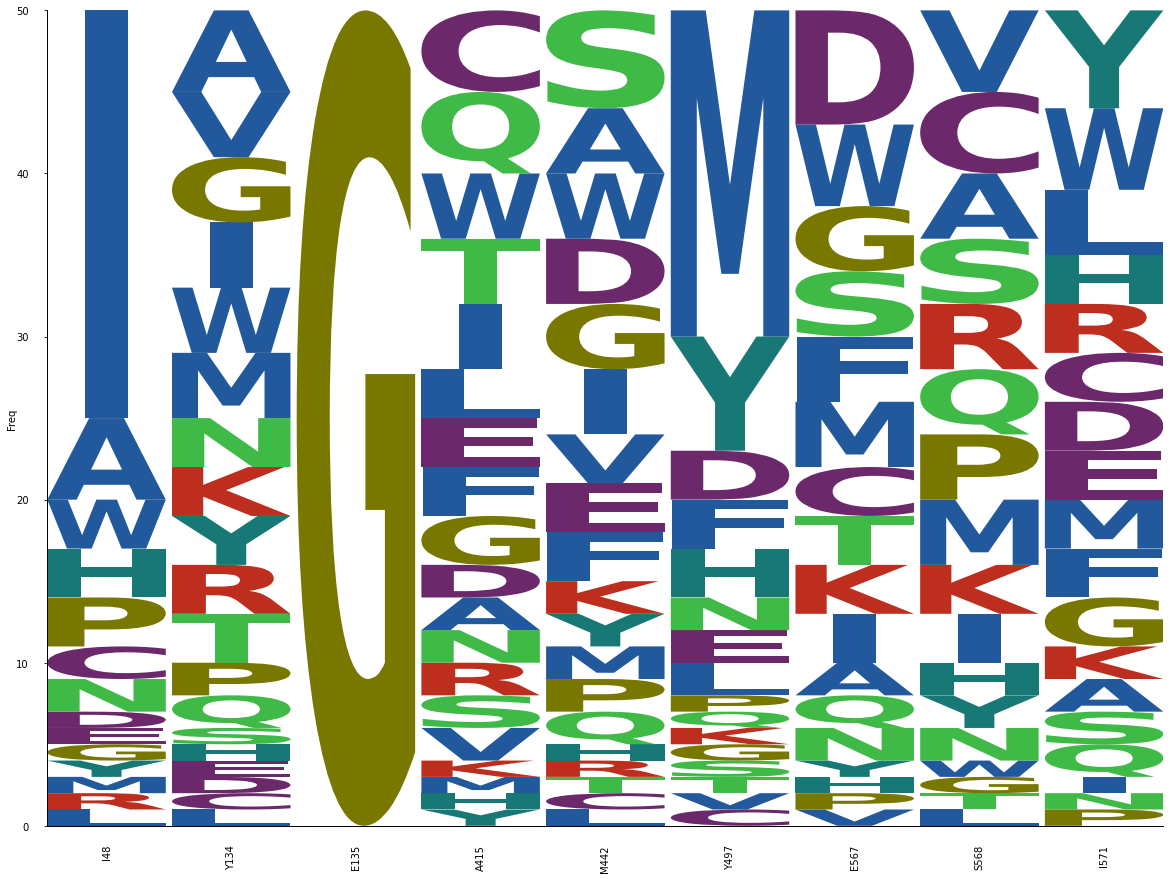

In [ ]:
def seq2logo(day=1):
    import math
    vol = pd.read_csv(f'Day_{day}/Volumes_{day}.csv')
    vol = vol[['I48_Type', 'Y134_Type', 'E135_Type',
               'A415_Type', 'M442_Type', 'Y497_Type',
               'E567_Type', 'S568_Type', 'I571_Type']]

    aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N','P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    table = pd.DataFrame(columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N','P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'],
                         index=pd.Index(['I48', 'Y134', 'E135', 'A415', 'M442', 'Y497', 'E567', 'S568', 'I571'], name='pos'))

    for col in ['I48', 'Y134', 'E135', 'A415', 'M442', 'Y497', 'E567', 'S568', 'I571']:
        for i in vol[f'{col}_Type']:
            if math.isnan(table.loc[col][i]):
                table.loc[col][i] = 1
            else:
                table.loc[col][i] += 1

    table = table.fillna(value=0)
    
    table.index = pd.Index([0,1,2,3,4,5,6,7,8] ,name='pos')

    # make Figure and Axes objects
    fig, ax = plt.subplots(1,1,figsize=[20,15])

    # create Logo object
    ss_logo = logomaker.Logo(table,
                             ax=ax,
                             color_scheme='NajafabadiEtAl2017',
                             font_name='Arial Rounded MT Bold')

    # style using Logo methods
    ss_logo.style_spines(visible=False)
    ss_logo.style_spines(spines=['left', 'bottom'], visible=True)
    ss_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

    #  style using Axes methods
    ax.set_ylabel("Freq", labelpad=-1)
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_tick_params(pad=-1)
    ax.tick_params(axis='both', which='major', pad=15)

    # style and save figure
    # Set the ticks and ticklabels for all axes
    plt.setp(ss_logo.ax, xticklabels=['I48', 'Y134', 'E135', 'A415', 'M442', 'Y497', 'E567', 'S568', 'I571'])

    return fig, ax

fig, ax = seq2logo(day=1)

In [ ]:
fig.savefig(f'Day_{day}_Logo.svg', format='svg', dpi=1200)

# All Data R2 CV 5

In [ ]:
day = 0
start_day = 0

In [ ]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=100, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

param_grid = {
            "learning_rate": [0.1, 0.3],
            "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
            "subsample": [0.9, 1.0],
            "n_estimators": [100, 300],
            "reg_lambda": [1.0],
            "gamma": [0, 0.1],
            "min_child_weight": [1, 2]}

# create the grid search object
model = XGBRegressor(objective = 'reg:squarederror')
grid = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid,
            cv=5,
            scoring= 'neg_mean_absolute_error',
            n_jobs=-1,
            n_iter = 48)

print('RandomSearchCV...')
grid.fit(aggregated_data_m.values, aggregated_label_m.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

RandomSearchCV...
RandomSearchCV Done!


In [ ]:
# create model
model = XGBRegressor(**results['params'].iloc[0])
# evaluate model
scores = cross_val_score(model, aggregated_data_m.values, aggregated_label_m.values, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('R2: %.3f (%.3f)' % (mean(scores), std(scores)))

R2: 0.648 (0.140)


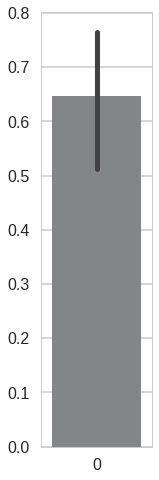

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
#plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(2,8))

ax = sns.barplot(data=scores, color='#828688')

In [ ]:
fig.savefig('5foldCrossValidation.svg', format='svg', dpi=1200)

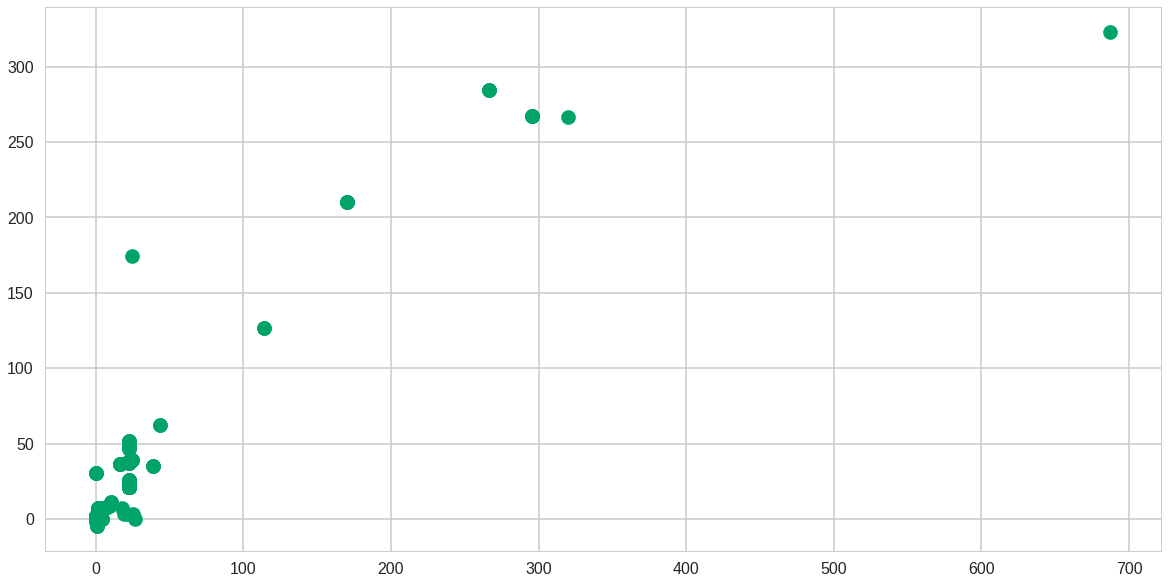

In [ ]:
from sklearn.model_selection import train_test_split
seed = 23
X_train, X_test, y_train, y_test = train_test_split(aggregated_data_m, aggregated_label_m, test_size = 0.2, random_state = seed)

model_plot = XGBRegressor(objective='reg:squarederror',**results['params'].iloc[0])
model_plot.fit(X_train, y_train)

"""plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')"""

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
#plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(20,10))

ax = plt.scatter(y_test, model_plot.predict(X_test), s=200, c='#00A368')

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, model_plot.predict(X_test))

0.8364059416136471

In [ ]:
fig.savefig('PredictedVsMeasured.svg', format='svg', dpi=1200)

# Visualising Results as BoxPlot


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


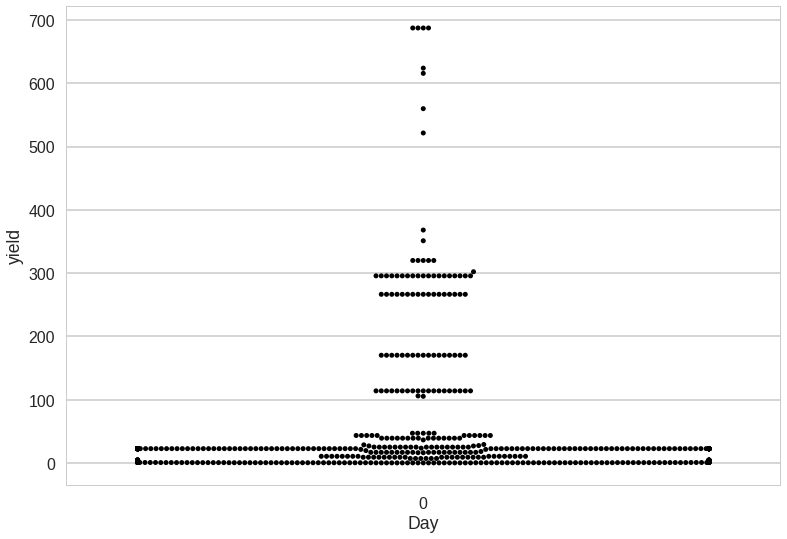

In [ ]:
display_std = True # if you have included "yield_std" column in Results.csv will show it else disply 0 for std

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

#ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=5)

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']

#ax.set_ylim(top=60000)
ax

In [ ]:
fig.savefig(f'Day_{day-1}_Boxplot.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Boxplot.svg', format='svg', dpi=1200)

# Visualising Results For Each Metabolite

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

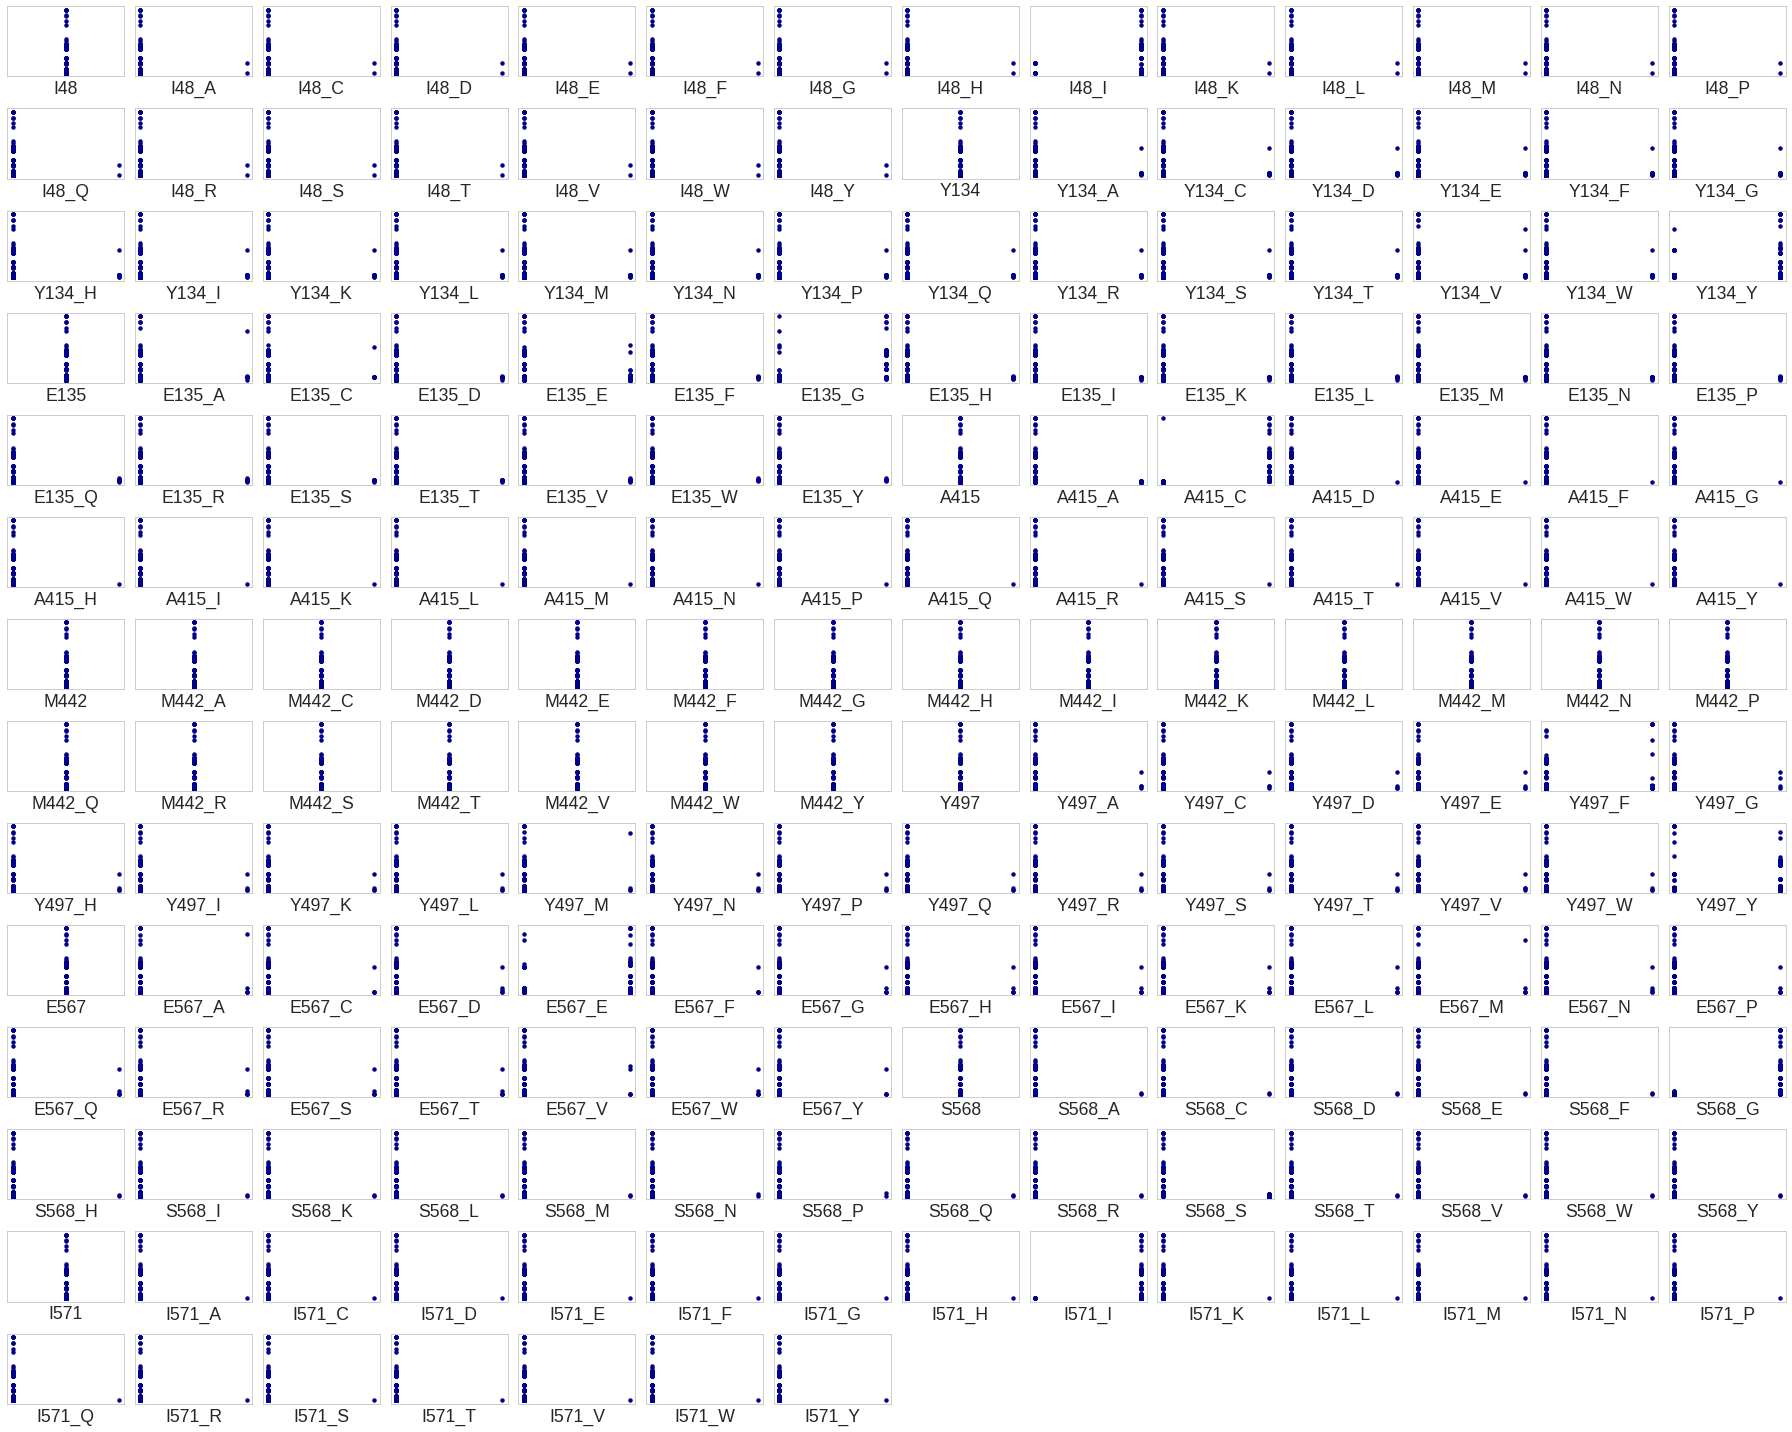

In [ ]:
desired_cols = []
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

plt.style.use('seaborn-whitegrid')

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

import matplotlib as mpl


#mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
#mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
#mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally
#mpl.rcParams['ytick.major.pad'] = 10.0 #set the value globally

fig = plt.figure(figsize=(25,20))

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', color='darkblue', data=data, s=20, linewidth=0)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)

    #plt.xlabel(desired_cols[i-1], labelpad=3 ,fontsize=5, weight='bold')


fig.tight_layout()

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Yield.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Yield.svg', format='svg', dpi=1200)

# Viualising Concentrations From Day_1 to Now

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

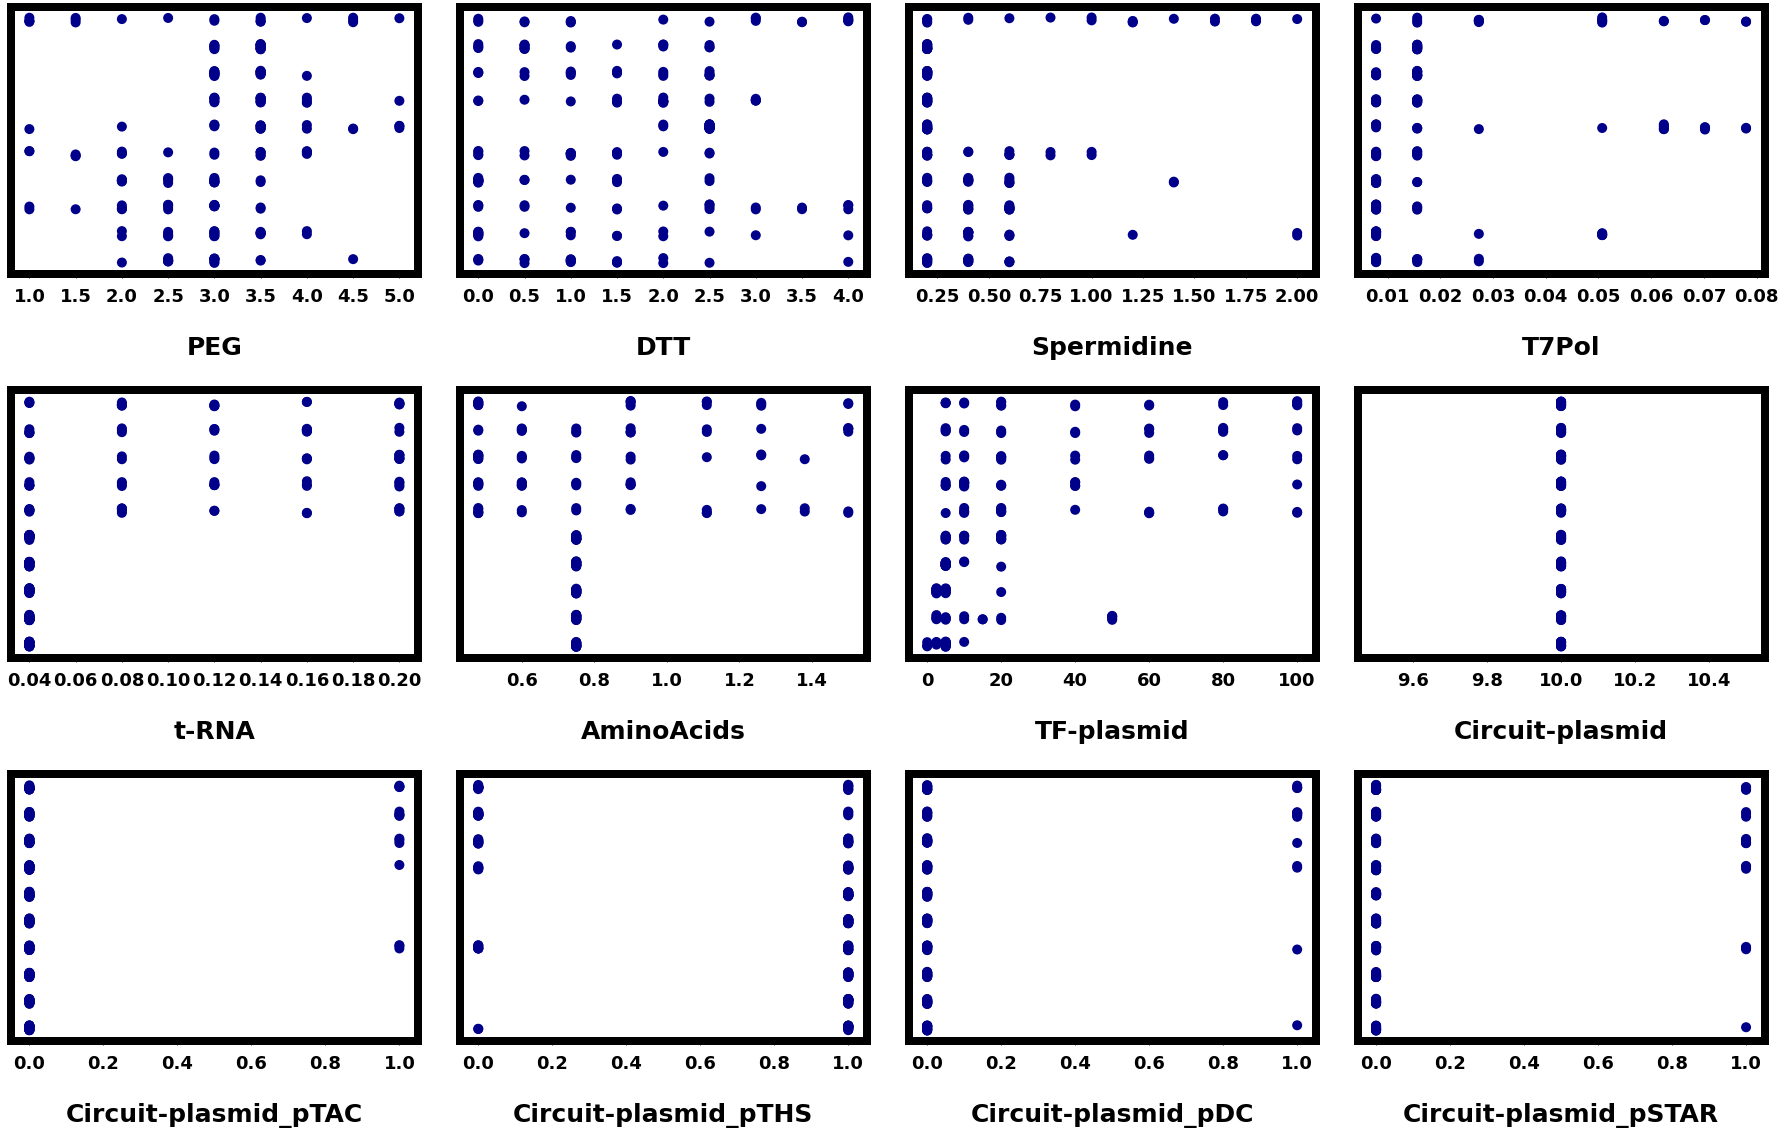

In [ ]:
data_all = pd.DataFrame(columns = list(concentrations_limits.keys())+['day'])
day = day_finder('Results')
desired_cols = []

# make column name:
desired_cols = []
for key, value in concentrations_limits.items():
    if not value['Alternatives']:
        desired_cols.append(key)
    else:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name

final_order = desired_cols

d = (1, 0)[os.path.isfile('Results_0.csv')]

while os.path.exists(f'Results_{d}.csv'):
    data = pd.read_csv(f'Results_{d}.csv')
    data = data[desired_cols]
    data = data.iloc[:days_range[d-1],:]
    data['day'] = f'Day_{d}'
    data_all = pd.concat([data_all, data]).reset_index(drop=True)
    d += 1

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally


num = len(desired_cols)
dim = math.ceil(math.sqrt(num))

fig = plt.figure(figsize=(25,20))
for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.stripplot(x=desired_cols[i-1], y="day", color='darkblue', data=data_all, s=10)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    ax.yaxis.set_ticklabels([])
    plt.xticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
data_all

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,day,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,Day_1,0.0,0.0,1.0,0.0
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,Day_1,0.0,0.0,1.0,0.0
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,Day_1,0.0,1.0,0.0,0.0
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,Day_1,0.0,0.0,0.0,1.0
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,Day_1,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.5,1.0,0.2,0.0156,0.04,0.75,5,10,Day_10,0.0,1.0,0.0,0.0
196,2.5,1.0,0.4,0.0273,0.04,0.75,5,10,Day_10,0.0,1.0,0.0,0.0
197,4.5,1.0,0.4,0.0078,0.04,0.75,5,10,Day_10,0.0,1.0,0.0,0.0
198,3.0,4.0,0.2,0.0273,0.04,0.75,5,10,Day_10,0.0,1.0,0.0,0.0


In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Days.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Days.svg', format='svg', dpi=1200)

# Transform Volumes.csv to Table2Speech Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Table2Speech_Volumes_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pSTAR,pTHS,pTAC,pDC,Lysate,EnergyBuffer,IPTG-Water,water
0,600.0,400.0,1000.0,1300.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2900.0
1,1800.0,0.0,400.0,1000.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3350.0
2,2000.0,100.0,500.0,1600.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2000.0
3,1400.0,300.0,100.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2700.0
4,1400.0,800.0,200.0,1000.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2800.0
5,1200.0,400.0,800.0,1800.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2350.0
6,1200.0,400.0,1000.0,200.0,100.0,2500.0,100.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,3700.0
7,1800.0,700.0,200.0,2000.0,100.0,2500.0,600.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,1300.0
8,1400.0,200.0,100.0,2000.0,100.0,2500.0,400.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,2500.0
9,400.0,300.0,1000.0,1300.0,100.0,2500.0,400.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,3200.0


In [ ]:
data.to_csv(f'Table2Speech_Volumes_{which_day}.csv', index=False)

# Transform Volumes.csv to ECHO liquid Handler Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Echo_Input_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder
plate_384_well = True
triplicate = False

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0


In [ ]:
intermediate = put_volumes_to_384_wells(data, starting_well='A1', vertical=False, make_csv=False)
intermediate[1]

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water,well_name
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A1
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0,A2
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0,A3
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0,A4
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0,A5
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A6
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0,A7
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0,A8
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0,A9
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0,A10


In [ ]:
intermediate[0]['pTHS']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,0.0,0.0,200.0,0.0,0.0,0.0,0.0,200.0,200.0,0.0,0.0,200.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
echo_input = source_to_destination(intermediate[1], desired_order=None, reset_index=True, check_zero=False)
echo_input[1]

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
...,...,...,...,...,...
295,Plate1,water well,destPlate1,A16,3550.0
296,Plate1,water well,destPlate1,A17,2850.0
297,Plate1,water well,destPlate1,A18,4300.0
298,Plate1,water well,destPlate1,A19,1200.0


In [ ]:
echo_input[1].to_csv(f'Echo_Input_{which_day}.csv', index=False)

In [ ]:
echo_input[0]['PEG']

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
5,Plate1,PEG well,destPlate1,A6,800.0
6,Plate1,PEG well,destPlate1,A7,1400.0
7,Plate1,PEG well,destPlate1,A8,1000.0
8,Plate1,PEG well,destPlate1,A9,600.0
9,Plate1,PEG well,destPlate1,A10,1400.0


# Find K Most Informative Combinations

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* specify in "k" i.e. how many Combinations you want to get 
* run all other cells!
* you can download K_Most_Informative_Combinations.csv file from Files that contain index of most informative combinations for 5 iterations</p1>

In [ ]:
k = 20
number_try = 200000
number_to_select = 5
n_iter = 200

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,0,0,1,0
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,0,0,1,0
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,0,1,0,0
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,0,0,0,1
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.5,1.0,0.2,0.0156,0.04,0.75,5,10,0,1,0,0
196,2.5,1.0,0.4,0.0273,0.04,0.75,5,10,0,1,0,0
197,4.5,1.0,0.4,0.0078,0.04,0.75,5,10,0,1,0,0
198,3.0,4.0,0.2,0.0273,0.04,0.75,5,10,0,1,0,0


In [ ]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

model = XGBRegressor(objective = 'reg:squarederror')
# create the grid search object
grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
print('RandomSearchCV ...')
grid.fit(aggregated_data_m.values, aggregated_label_m.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
indexs = []
num = 0
while num < number_try:
    numbers = set()
    while len(numbers) < k:
        numbers.add(random.randint(0, len(aggregated_data_m)-1))
    indexs.append(numbers)
    num += 1

In [ ]:
performance = []
best_param = results.params.iloc[0,]
all_set = set(range(len(aggregated_data_m)))
counter = 0
for index in indexs:
    counter += 1
    if counter%100 == 0:print(counter)
    index_test = all_set - index
    index_test = list(index_test)
    index = list(index)
    model = XGBRegressor(objective = 'reg:squarederror', **best_param)
    model.fit(aggregated_data_m.iloc[index].values, aggregated_label_m.iloc[index].values)
    performance.append(spearmanr(model.predict(aggregated_data_m.iloc[index_test].values), aggregated_label_m.iloc[index_test].values).correlation**2)

performance = np.array(performance)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [ ]:
ind = np.argpartition(performance, -number_to_select)[-number_to_select:]
performance[ind]

array([0.72514552, 0.72569884, 0.72726853, 0.72938257, 0.75793557])

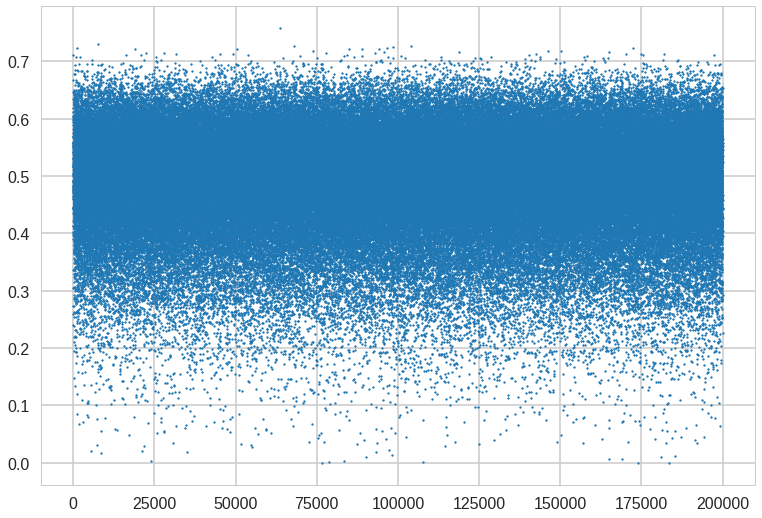

In [ ]:
plt.scatter(range(len(performance)), performance, s=3)

In [ ]:
df_perfomance = pd.DataFrame({'performance':performance, 'index_values':indexs}).sort_values('performance', ascending=False)
df_perfomance.iloc[0:5, :]

,performance,index_values
63734,0.757936,"{96, 34, 99, 68, 197, 39, 7, 167, 76, 13, 46, ..."
7728,0.729383,"{160, 161, 66, 38, 134, 136, 104, 74, 107, 46,..."
67957,0.727269,"{68, 165, 135, 136, 9, 107, 44, 13, 46, 79, 49..."
103929,0.725699,"{96, 98, 163, 132, 71, 8, 105, 135, 107, 12, 7..."
98571,0.725146,"{64, 128, 99, 68, 135, 170, 11, 172, 138, 46, ..."


In [ ]:
df_perfomance.iloc[0:5, :].index_values

63734     {96, 34, 99, 68, 197, 39, 7, 167, 76, 13, 46, ...
7728      {160, 161, 66, 38, 134, 136, 104, 74, 107, 46,...
67957     {68, 165, 135, 136, 9, 107, 44, 13, 46, 79, 49...
103929    {96, 98, 163, 132, 71, 8, 105, 135, 107, 12, 7...
98571     {64, 128, 99, 68, 135, 170, 11, 172, 138, 46, ...
Name: index_values, dtype: object

In [ ]:
for i, index in enumerate(df_perfomance.iloc[0:5, :].index_values):
    aggregated_data_m.iloc[list(index),:].to_csv(f'{k}_Most_Informative_Combinations_Rank{i+1}.csv', index=False)

# Find Feature Importances


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download importance_df.csv  from Files</p1>

In [ ]:
n_iter = 200

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

In [ ]:
importance_list = []
print('This may takes minutes!')

for day_i in range(start_day, day+1):
    aggregated_data_m = pd.DataFrame(columns=desired_cols)
    aggregated_label_m = pd.DataFrame(columns=['yield'])

    for num in range(start_day, day_i + 1):
        if start_day or num>0:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
        else:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

        aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
        aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # creat estimator
    model = XGBRegressor(objective = 'reg:squarederror')

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...', day_i)
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print('RandomSearchCV Done!')

    model = XGBRegressor(objective = 'reg:squarederror', **results.params.iloc[0,])
    model.fit(aggregated_data_m.values, aggregated_label_m.values)
    importance_list.append(model.feature_importances_)

This may takes minutes!
RandomSearchCV ... 0
RandomSearchCV Done!


In [ ]:
importance_df = pd.DataFrame(importance_list, columns=aggregated_data_m.columns)
importance_df

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007371,...,0.0,0.0,0.0,0.0,0.033756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
importance_df.to_csv('importance_df.csv', index=False)

* find feature importance through 
sklearn.feature_selection.mutual_info_regression

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(aggregated_data_m.values)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(aggregated_label_m.values)

In [ ]:
importance_df_sklearn = pd.DataFrame(mutual_info_regression(X, y)).T
importance_df_sklearn.columns = aggregated_data_m.columns
importance_df_sklearn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.011448,0.0,0.0,0.0,0.004065,0.004446,0.034103,0.00737,0.147194,0.0,0.0,0.0,0.037292,0.005787,0.0,0.0,0.0,0.0,0.007065,0.0,0.004776,0.002748,0.008567,0.025717,0.0,0.0,0.025055,0.0,0.0,0.003238,0.022058,0.012899,0.010453,0.003717,0.051774,0.078904,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01029,0.5716,0.041459,0.010387,0.0,0.026341,0.0,0.014965,0.0,0.024792,0.032277,0.537486,0.0,0.0,0.025215,0.0,0.0,0.0,0.0,0.0,0.001011,0.00861,0.0,0.020945,0.08854,0.002757,0.018478,0.007368,0.022716,0.022613,0.035679,0.007834,0.0,0.006809,0.0,0.002723,0.052194


In [ ]:
importance_df_sklearn.to_csv('importance_df_sklearn.csv', index=False)


## Visualize Feature Importance

In [ ]:
importance_df

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007371,...,0.0,0.0,0.0,0.0,0.033756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
importance_df[list(importance_df.loc[0][importance_df.loc[0]>0].index)]

,I48_I,Y134_V,Y134_Y,E135_A,E135_C,E135_E,E135_G,A415_C,Y497_F,Y497_M,Y497_Y,E567_A,E567_E,E567_M,E567_V,S568_G,S568_S
0,0.084797,0.007371,0.099748,0.007938,0.01045,0.007062,0.397187,0.005738,0.20952,0.013469,0.053749,0.01653,0.030909,0.008705,0.00913,0.033756,0.003942


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

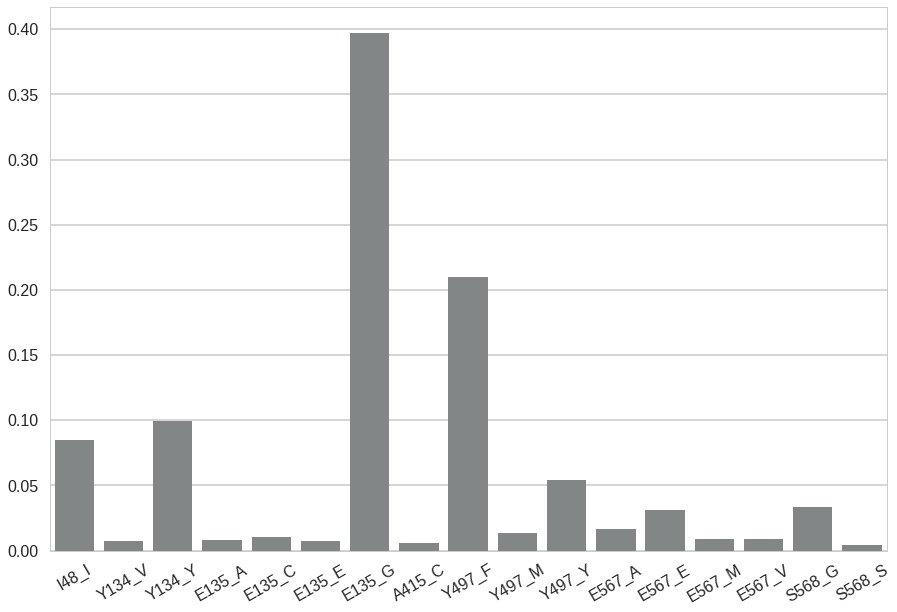

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.barplot(data=importance_df[list(importance_df.loc[0][importance_df.loc[0]>0].index)], color='#828688')
#ax = plt.plot(list(importance_df.loc[0][importance_df.loc[0]>0]), marker='o', ls='', color='k', label='Last Round')

plt.legend()
plt.xticks(rotation=30)

In [ ]:
#fig.savefig('importance_df.png', format='png', dpi=1200)
fig.savefig('importance_df.svg', format='svg', dpi=1200)

# Find NonLinear Interactions

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download Interactions.png from Files</p1>

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

NameError: ignored

In [ ]:
from sklearn.linear_model import LinearRegression
from itertools import combinations

model = LinearRegression()
model.fit(aggregated_data_m.values, aggregated_label_m.values)
baseline_score = pearsonr(pd.DataFrame(model.predict(aggregated_data_m.values))[0] ,aggregated_label_m['yield'])
baseline_score

(0.5721969404307963, 8.0263411016243e-75)

In [ ]:
interaction_scores = {}
for i in combinations(aggregated_data_m.columns, 2):
    X = pd.concat([aggregated_data_m, (aggregated_data_m[i[0]] * aggregated_data_m[i[1]])], axis=1)
    y = aggregated_label_m

    model = LinearRegression()
    model.fit(X.values, y.values)
    score = pearsonr(pd.DataFrame(model.predict(X.values))[0] ,y['yield'])

    interaction_scores[i] = score

In [ ]:
interactions_df = pd.DataFrame(data=np.zeros([len(aggregated_data_m.columns), len(aggregated_data_m.columns)]), columns=aggregated_data_m.columns, index=aggregated_data_m.columns)

for columns, value in interaction_scores.items():
    diff = value[0] - baseline_score[0]
    interactions_df[columns[0]][columns[1]] = diff

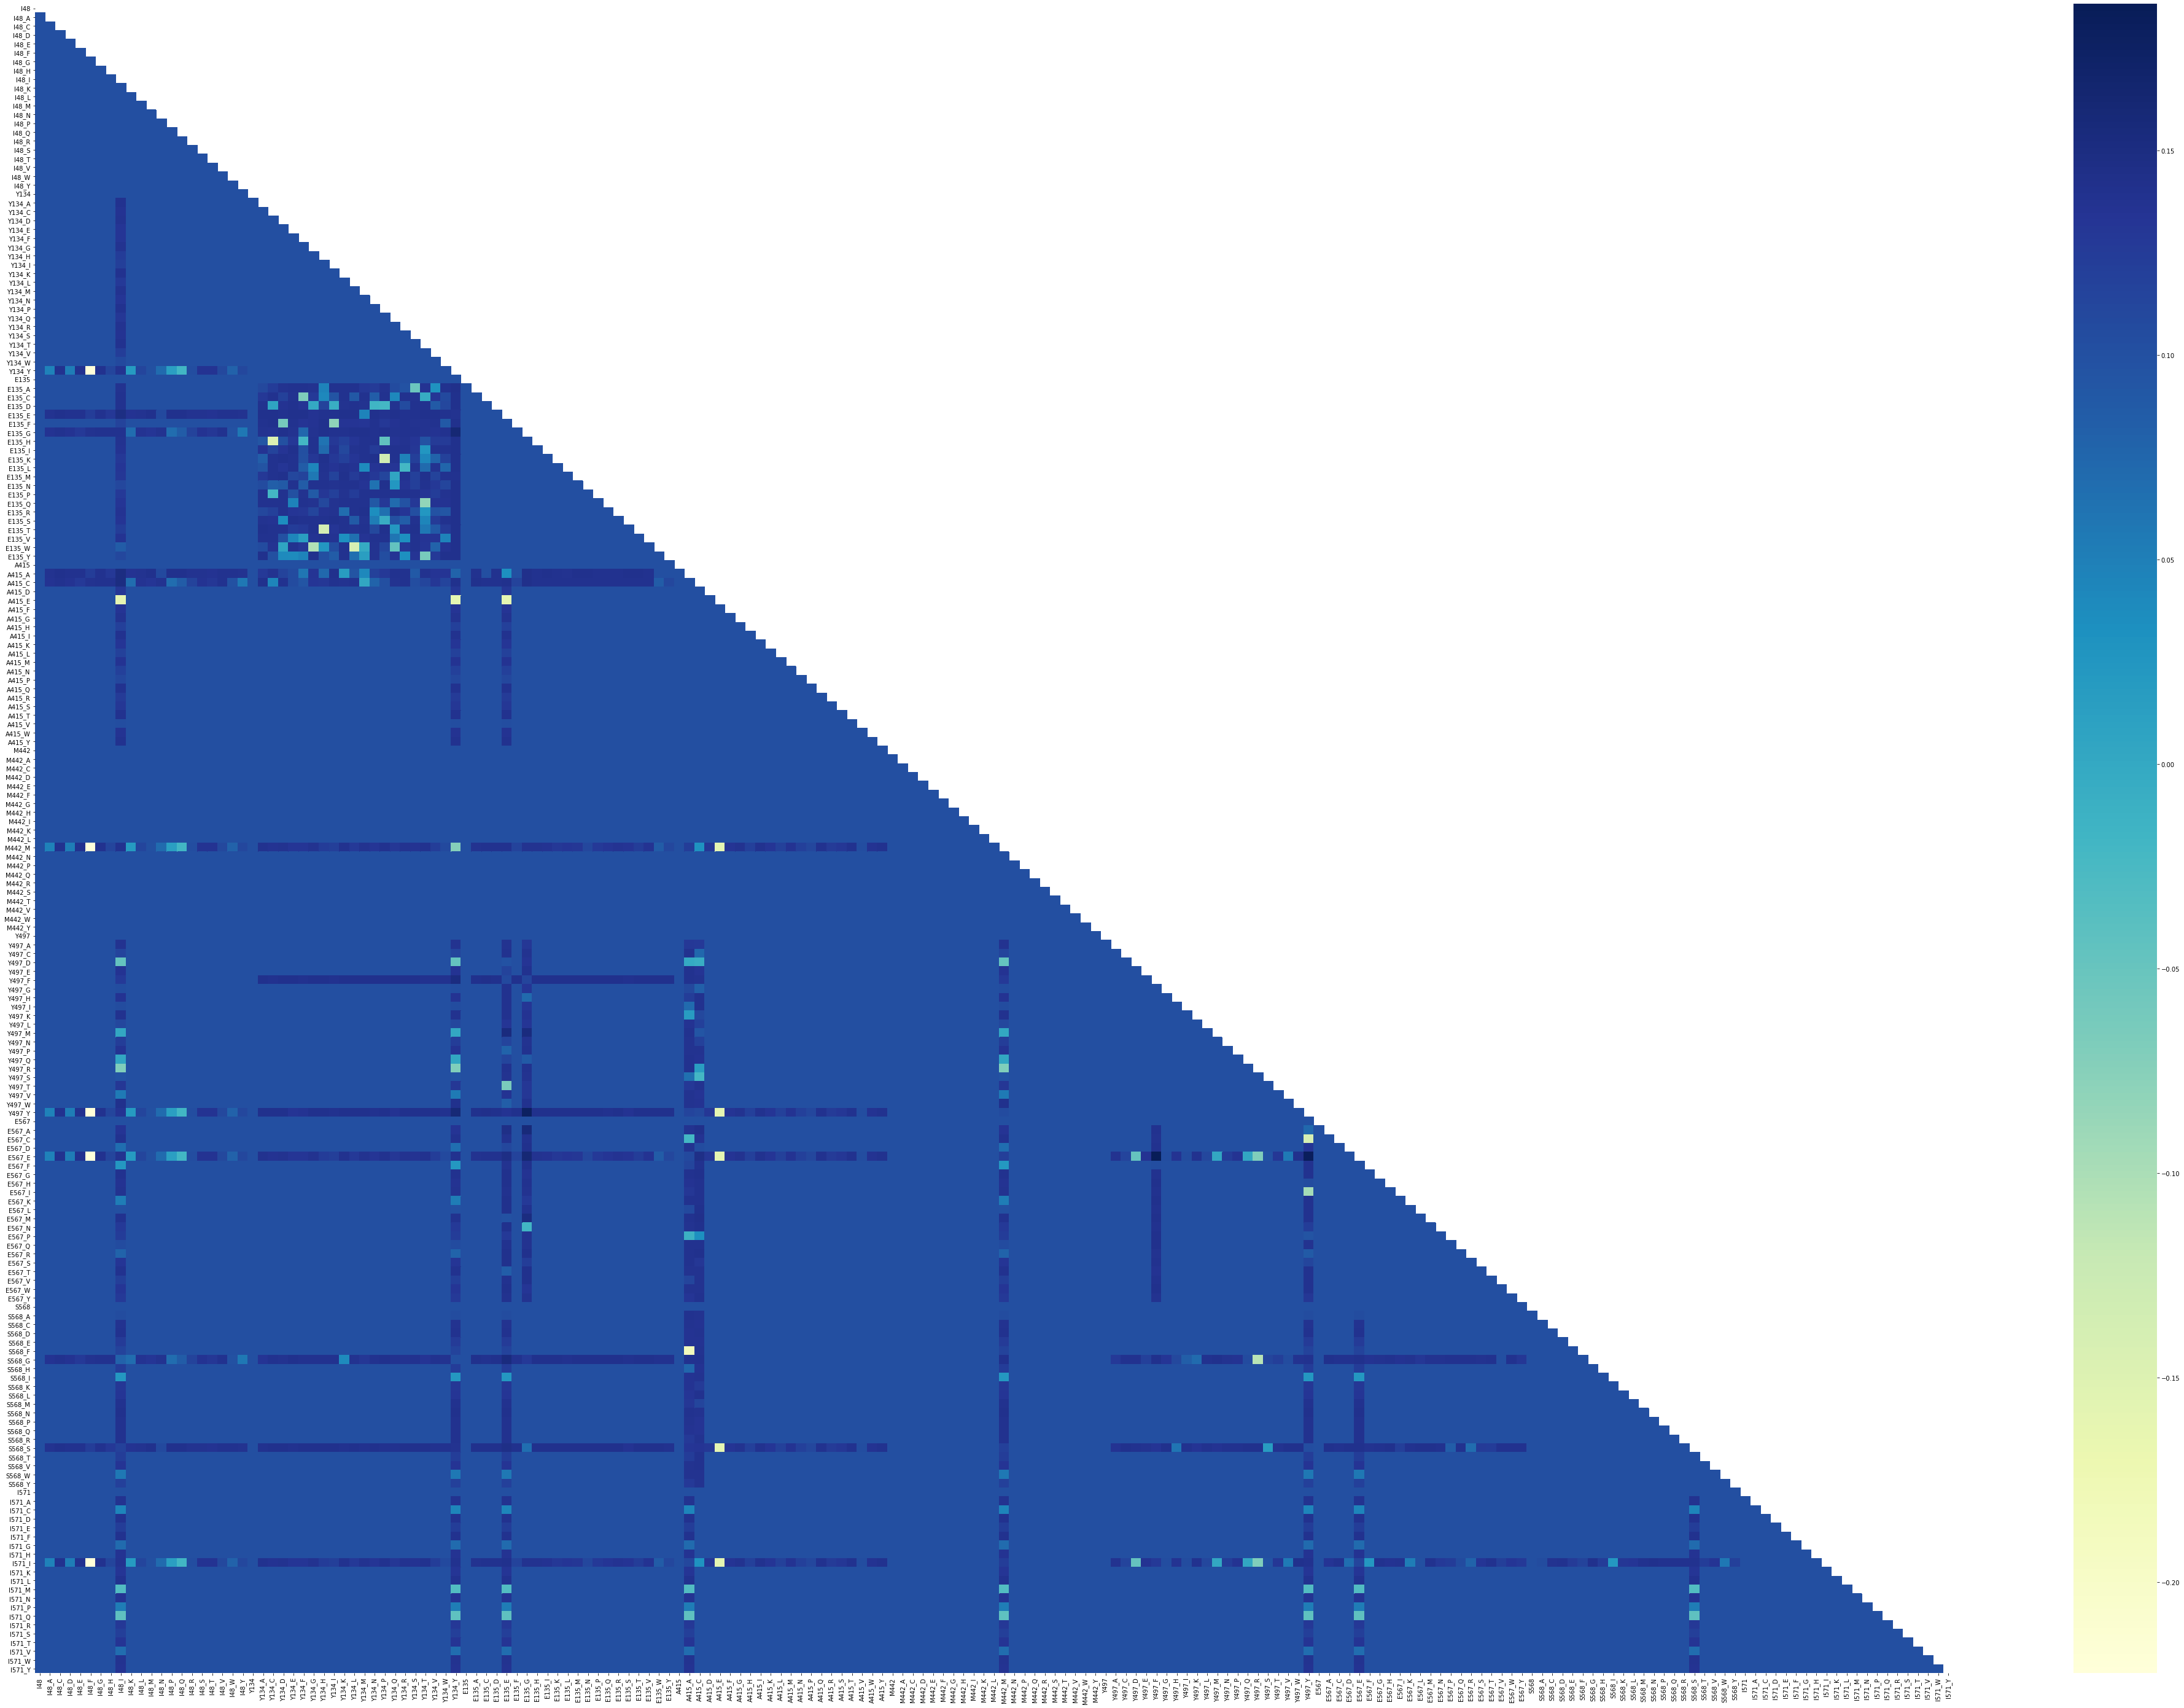

In [ ]:
corr = np.corrcoef(np.random.randn(len(aggregated_data_m.columns), 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (70,50))
ax = sns.heatmap(interactions_df, mask=mask, cmap='YlGnBu')

In [ ]:
fig.savefig('Interactions.png', format='png', dpi=600)
fig.savefig('Interactions.svg', format='svg', dpi=600)

NameError: ignored